✅ Imports ready
Shape before cleaning: (102599, 26)
Shape after cleaning: (102058, 26)
<class 'pandas.core.frame.DataFrame'>
Index: 102058 entries, 0 to 102057
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102058 non-null  int64  
 1   NAME                            101808 non-null  object 
 2   host id                         102058 non-null  int64  
 3   host_identity_verified          101769 non-null  object 
 4   host name                       101654 non-null  object 
 5   neighbourhood group             102029 non-null  object 
 6   neighbourhood                   102042 non-null  object 
 7   lat                             102050 non-null  float64
 8   long                            102050 non-null  float64
 9   country                         101526 non-null  object 
 10  country code                    101927 non-null  object 
 

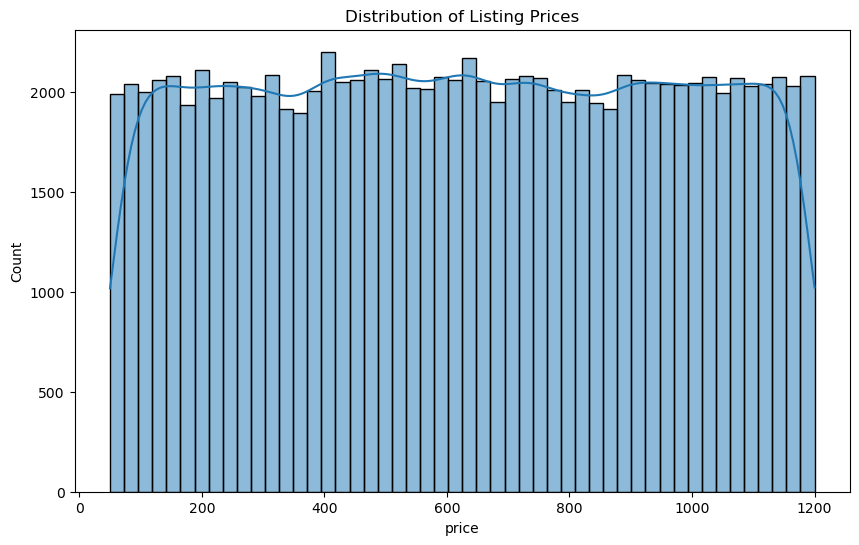

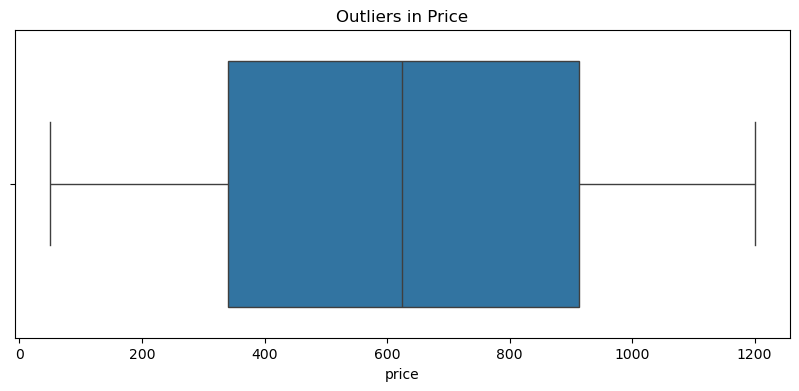

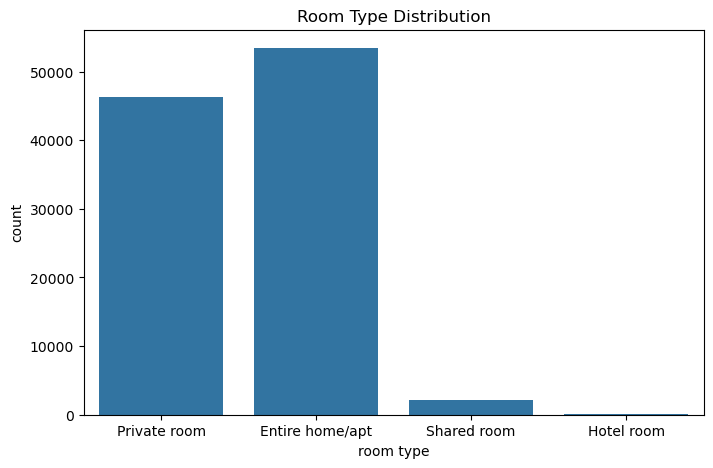

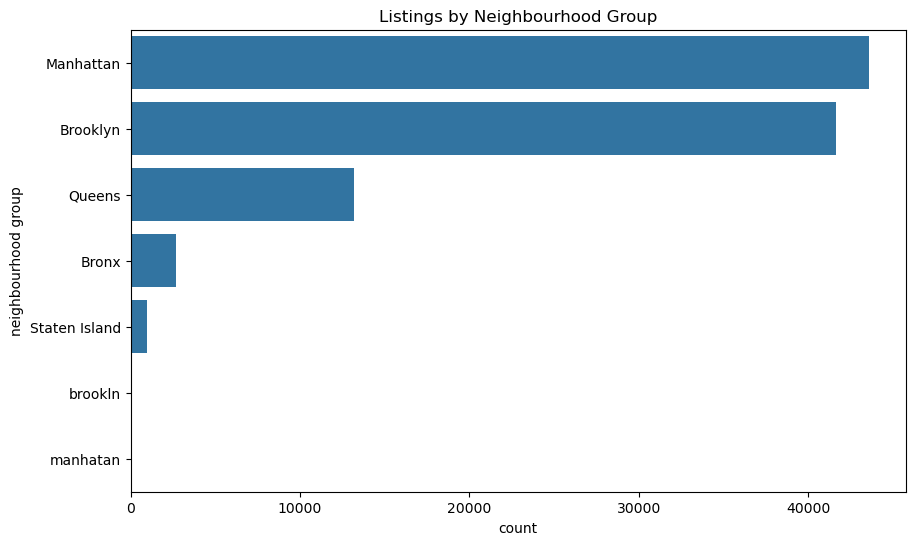

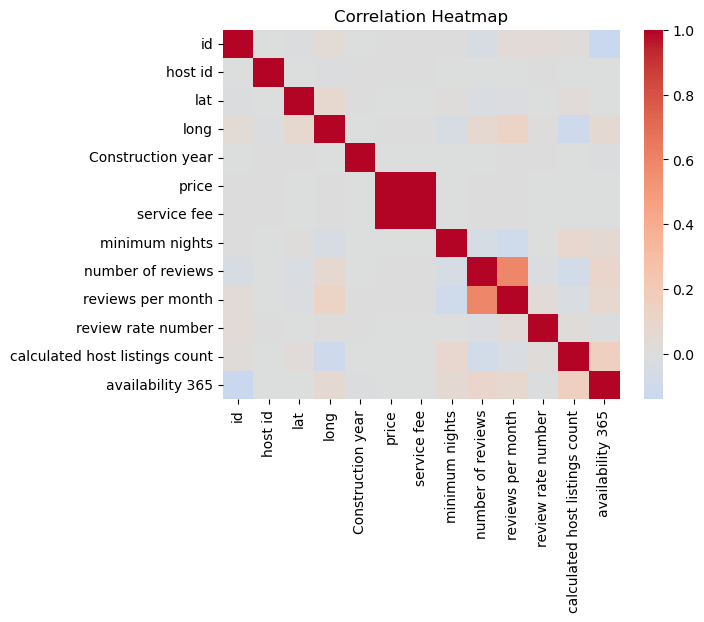

✅ Engineered columns: ['price_per_review', 'host_listings_ratio', 'demand']
✅ ML dataset ready: (84102, 30)
Dropping leakage columns: ['price', 'number of reviews', 'reviews per month', 'review rate number', 'availability 365', 'price_per_review', 'demand']
MAE: 1.64
R²: 0.997


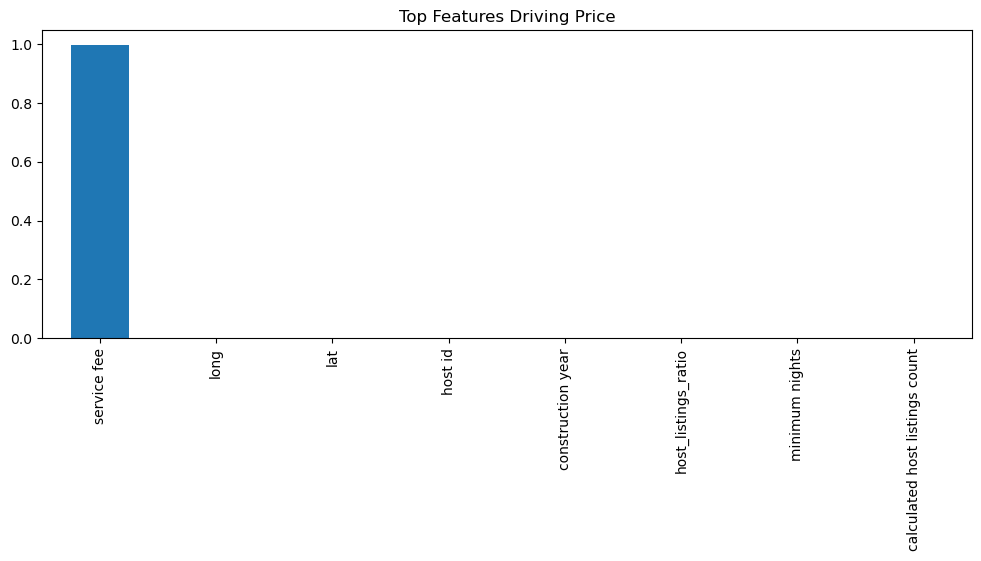

Cross-validated accuracy: 0.822

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      8514
           1       0.79      0.80      0.80      8234

    accuracy                           0.80     16748
   macro avg       0.80      0.80      0.80     16748
weighted avg       0.80      0.80      0.80     16748



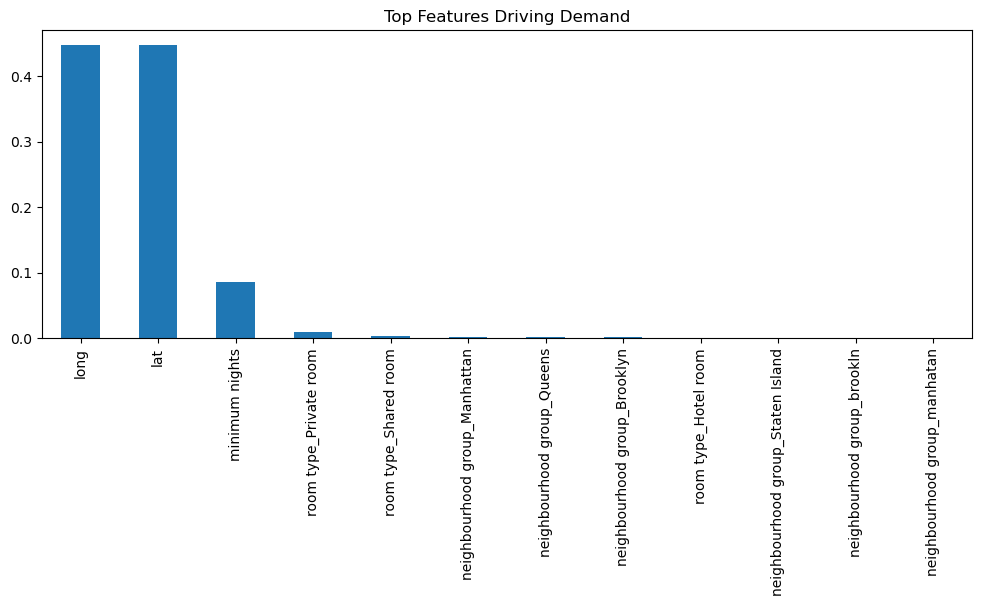

✅ Compressed dataset saved as Airbnb_Cleaned_Ready.csv.gz


In [3]:
# ==============================================
# 1. Imports
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print("✅ Imports ready")

# ==============================================
# 2. Load Data
# ==============================================
csv_path = "Airbnb_Data_Uncleaned.csv"
df = pd.read_csv(csv_path, low_memory=False)
print(f"Shape before cleaning: {df.shape}")

# Clean currency columns
for money_col in ['price','service fee']:
    if money_col in df.columns and df[money_col].dtype == 'object':
        df[money_col] = (
            df[money_col].astype(str)
            .str.replace(r'[\$,]', '', regex=True)
            .replace({'': np.nan})
            .astype(float)
        )

# Drop duplicates
df = df.drop_duplicates()

print(f"Shape after cleaning: {df.shape}")
df.info()

# ==============================================
# 3. Exploratory Data Analysis
# ==============================================
if 'price' in df.columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df['price'].dropna(), bins=50, kde=True)
    plt.title('Distribution of Listing Prices')
    plt.show()

    plt.figure(figsize=(10,4))
    sns.boxplot(x=df['price'])
    plt.title('Outliers in Price')
    plt.show()

if 'room type' in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x='room type')
    plt.title('Room Type Distribution')
    plt.show()

if 'neighbourhood group' in df.columns:
    plt.figure(figsize=(10,6))
    order = df['neighbourhood group'].value_counts().index
    sns.countplot(data=df, y='neighbourhood group', order=order)
    plt.title('Listings by Neighbourhood Group')
    plt.show()

corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# ==============================================
# 4. Feature Engineering
# ==============================================
if {'price','number of reviews'}.issubset(df.columns):
    df['price_per_review'] = df['price'] / (df['number of reviews'] + 1)

if {'calculated host listings count','number of reviews'}.issubset(df.columns):
    df['host_listings_ratio'] = df['calculated host listings count'] / (df['number of reviews'] + 1)

if 'number of reviews' in df.columns:
    demand_threshold = df['number of reviews'].median()
    df['demand'] = (df['number of reviews'] > demand_threshold).astype(int)

if 'price' in df.columns:
    df = df[df['price'].between(0, 1000)]  # remove extreme outliers
    df = df.dropna(subset=['price'])

print("✅ Engineered columns:", [c for c in ['price_per_review','host_listings_ratio','demand'] if c in df.columns])

# ==============================================
# 5. ML Dataset Preparation
# ==============================================
cat_cols = [c for c in ['room type','neighbourhood group','instant_bookable',
                        'cancellation_policy','host_identity_verified'] if c in df.columns]

df_ml = pd.get_dummies(df, columns=cat_cols, drop_first=True)

drop_cols = [c for c in ['id','NAME','host name','country','country code','neighbourhood','last review'] if c in df_ml.columns]
df_ml = df_ml.drop(columns=drop_cols, errors='ignore')

df_ml.columns = [c.lower().strip() for c in df_ml.columns]

print("✅ ML dataset ready:", df_ml.shape)

# ==============================================
# 6. Price Prediction (Regression)
# ==============================================
if 'price' in df_ml.columns:
    leakage_cols = [col for col in df_ml.columns if 'price' in col or 'review' in col or 'avail' in col or 'demand' in col]
    print("Dropping leakage columns:", leakage_cols)

    X_reg = df_ml.drop(columns=leakage_cols, errors='ignore').select_dtypes(include=[np.number]).fillna(0)
    y_reg = np.log1p(df_ml['price'])

    X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

    reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    y_test_orig, y_pred_orig = np.expm1(y_test), np.expm1(y_pred)

    print("MAE:", round(mean_absolute_error(y_test_orig, y_pred_orig), 2))
    print("R²:", round(r2_score(y_test_orig, y_pred_orig), 3))

    pd.Series(reg.feature_importances_, index=X_reg.columns).sort_values(ascending=False).head(15).plot(
        kind='bar', figsize=(12,4), title='Top Features Driving Price')
    plt.show()

# ==============================================
# 7. Demand Prediction (Classification, Safe Features Only)
# ==============================================
if 'demand' in df.columns:
    safe_cols = ["lat", "long", "neighbourhood group", "room type", "minimum nights"]
    df_clf = df[safe_cols + ["demand"]].dropna()

    df_clf = pd.get_dummies(df_clf, columns=["neighbourhood group","room type"], drop_first=True)

    X_clf = df_clf.drop(columns=["demand"])
    y_clf = df_clf["demand"]

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1)
    scores = cross_val_score(clf, X_clf, y_clf, cv=5, scoring="accuracy", n_jobs=-1)

    print("Cross-validated accuracy:", round(scores.mean(), 3))

    X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    pd.Series(clf.feature_importances_, index=X_clf.columns).sort_values(ascending=False).head(15).plot(
        kind='bar', figsize=(12,4), title='Top Features Driving Demand')
    plt.show()

# ==============================================
# 8. Save Cleaned Data
# ==============================================
df.to_csv("Airbnb_Cleaned_Ready.csv.gz", index=False, compression="gzip")
print("✅ Compressed dataset saved as Airbnb_Cleaned_Ready.csv.gz")


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
import joblib

# -------------------------------
# Train Price Prediction Model
# -------------------------------
leakage_cols = [col for col in df_ml.columns if 
                'price' in col.lower() or 
                'review' in col.lower() or 
                'avail' in col.lower()]

X_reg = df_ml.drop(columns=leakage_cols, errors='ignore').select_dtypes(include=[np.number]).fillna(0)
y_reg = np.log1p(df_ml['price'])

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
reg.fit(X_train, y_train)

# -------------------------------
# Train Demand Prediction Model
# -------------------------------
leakage_cols_clf = [col for col in df_ml.columns if 
                    'price' in col.lower() or 
                    'review' in col.lower() or 
                    'avail' in col.lower() or 
                    'demand' in col.lower()]

X_clf = df_ml.drop(columns=leakage_cols_clf, errors='ignore').select_dtypes(include=[np.number]).fillna(0)
y_clf = df['demand']

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
clf.fit(X_clf, y_clf)

# -------------------------------
# Save Models + Features
# -------------------------------
joblib.dump(reg, "reg_model.pkl")
joblib.dump(clf, "clf_model.pkl")
joblib.dump(list(X_reg.columns), "reg_features.pkl")
joblib.dump(list(X_clf.columns), "clf_features.pkl")

print("✅ Models and features saved successfully!")


✅ Models and features saved successfully!
